# Do not forget paste your hf token for meta-llama/Meta-Llama-3.1-8B-Instruct

In [ ]:
from huggingface_hub import login
print("Login...")
# Huggingface login
TOKEN = 'HF_TOKEN' 
login(token=TOKEN)
print("logged")

# Data example below

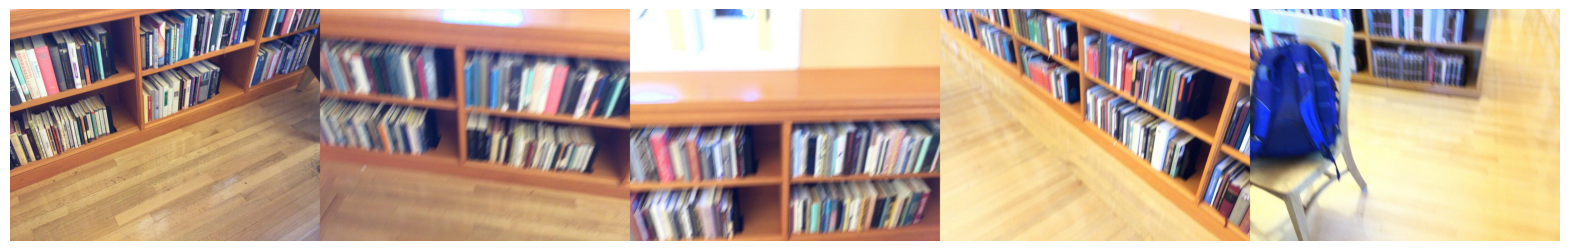

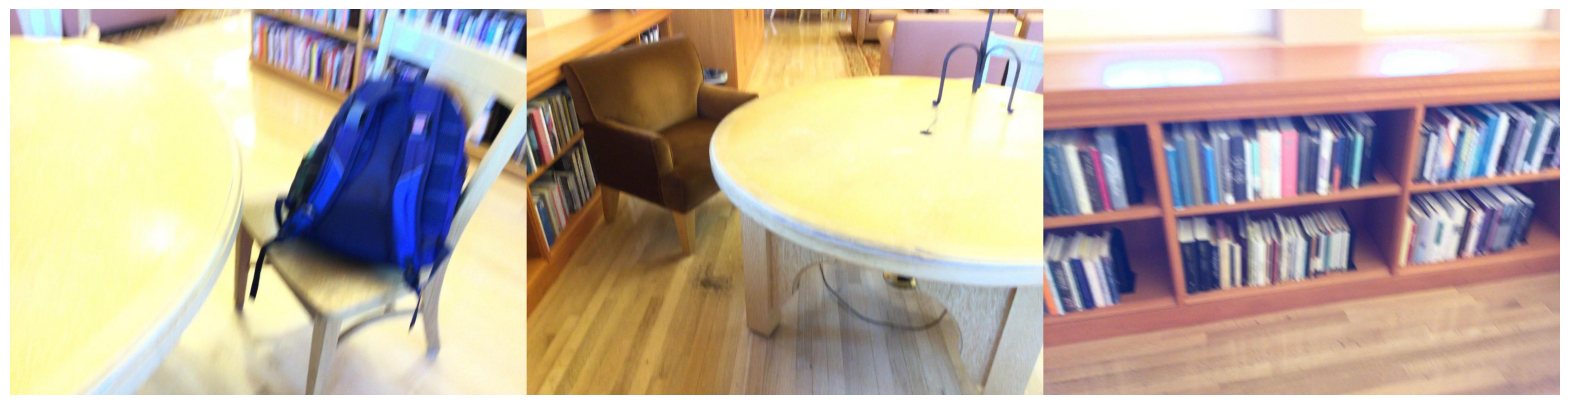

In [1]:
import os
from time import sleep

from io import BytesIO
import PIL
from IPython.display import display, Image

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

def display_img_array(ima):
    im = PIL.Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png'))

def display2(images):
    # Stack images horizontally
    stacked_images = np.hstack(images)
    
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    stacked_images = cv2.cvtColor(stacked_images, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(20, 10))  # Adjust the size as needed
    plt.imshow(stacked_images)
    plt.axis('off')  # Hide axis
    plt.show()



def read_images(paths):
    arr = []
    for path in sorted(paths):
        if path.split('.')[-1] not in ['jpg', 'png', 'jpeg']:
            print(path.split('.')[-1])
            continue
        else:
            arr.append(cv2.imread(path))
    return arr

path = 'data/tasks/scannet_frames_25k/' + random.choice(os.listdir('data/tasks/scannet_frames_25k/')) + '/color/'
#path = 'data/tasks/scannet_frames_25k/scene0207_01/color/'
bs = 5

paths = sorted(os.listdir(path))
for i in range(len(paths)):
    paths[i] = path + paths[i]
for i in range(0, len(paths), bs):
    image_batch = read_images(paths[i:min(len(paths), i + bs)])
    display2(image_batch)

In [2]:
import os
os.listdir("data/tasks/scannet_frames_25k")[1:10]

['scene0532_00',
 'scene0613_02',
 'scene0628_00',
 'scene0631_02',
 'scene0310_01',
 'scene0059_02',
 'scene0083_01',
 'scene0686_01',
 'scene0143_00']

In [3]:
images_path = 'data/tasks/scannet_frames_25k/' + random.choice(os.listdir('data/tasks/scannet_frames_25k/')) + '/color'
paths = []
for path in sorted(os.listdir(images_path)):
    if path.split('.')[-1] == 'jpg':
        paths.append(images_path + '/' + path)
paths

['data/tasks/scannet_frames_25k/scene0020_01/color/000000.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000100.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000200.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000300.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000400.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000500.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000600.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000700.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000800.jpg',
 'data/tasks/scannet_frames_25k/scene0020_01/color/000900.jpg']

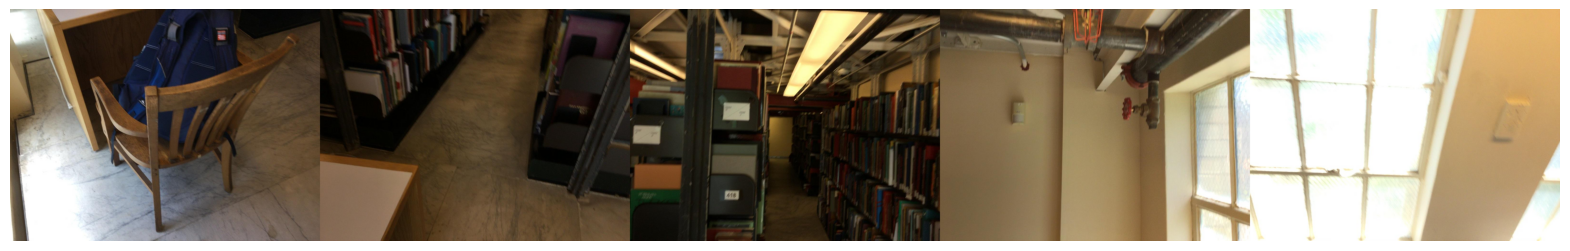

In [4]:
paths = paths[::2]
imgs = read_images(paths)
display2(imgs)

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch



pretrained = "lmms-lab/llama3-llava-next-8b"
model_name = "llava_llama3"
device = "cuda"
device_map = "auto"
tokenizer, model, image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map, attn_implementation=None) # Add any other thing you want to pass in llava_model_args

model.eval()
model.tie_weights()

In [6]:
items_full = []
for image_num in range(0, len(paths)):
    image = paths[image_num]
    inp = '''
    Please look at the image and identify the key elements in the room.
    List each object with a very short description, 
    focusing on important items like furniture, decorations,
    and electronics. Do not generalize furniture. Describe their appearance and relative position in the room.
    
    Try to make list as small as possible
    list should look like this:
    1. Item 1
    2. Item 2
    3. Item 3
    Do not write '.' in the end of list element
    '''
    
    image = Image.open(image)
    image_tensor = process_images([image], image_processor, model.config)
    image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]
    
    conv_template = "llava_llama_3" # Make sure you use correct chat template for different models
    question = DEFAULT_IMAGE_TOKEN + inp
    conv = copy.deepcopy(conv_templates[conv_template])
    conv.append_message(conv.roles[0], question)
    conv.append_message(conv.roles[1], None)
    prompt_question = conv.get_prompt()
    
    input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
    image_sizes = [image.size]
    
    
    cont = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=image_sizes,
        do_sample=False,
        temperature=0.2,
        max_new_tokens=512,
    )
    text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
    
    items = text_outputs[0].split('\n')
    if items[0] == '':
        items = items[1::]
    for i in range(len(items)):
        if ". " in items[i]:
            items[i] = items[i].split(". ")[-1]
    
    items = list(set(items))
    items_full += items
    print(f"Done {(image_num + 1) / len(paths) * 100} %")

/home/user22/anaconda3/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Done 20.0 %


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Done 40.0 %


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Done 60.0 %


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Done 80.0 %


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Done 100.0 %


In [7]:
items_full = list(set(items_full))
items_full

['Wooden desk with drawers.',
 'Wooden bookshelf with books and papers',
 'Floor with a patterned design.',
 'Pipe running along the ceiling',
 'Wooden bookshelf with books',
 'Black filing cabinet',
 'Window with frosted glass',
 'Wooden chair with blue backpack on it.',
 'Wall with a gray color on the right side of the room.',
 'Red valve on the pipe',
 'Bookshelf with books and papers',
 'Electrical outlet on wall',
 'Window with a view of the outside',
 'Bookshelf with books on the left side of the room.',
 'Metal beams on ceiling',
 'Marble floor.',
 'White papers taped to filing cabinet',
 'Fluorescent lighting fixtures',
 'Table with a white surface on the left side of the room.',
 'Cardboard boxes on top of bookshelf',
 'White smoke detector on the wall',
 'Bookshelf with books on the right side of the room.',
 'Sunlight shining through window',
 '51.']

In [8]:
room_types = [
    "Kitchen",
    "Living Room",
    "Bedroom",
    "Bathroom",
    "Dining Room",
    "Office",
    "Garage",
    "Laundry Room",
    "Hallway",
    "Closet",
    "Basement",
    "Attic",
    "Guest Room",
    "Home Gym",
    "Home Theater",
    "Playroom",
    "Study",
    "Sunroom",
    "Pantry",
    "Mudroom"
]

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2-7B-Instruct"
device = "cuda:0" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

items_list = "\n".join(items_full)
types_list = "\n".join(room_types)

prompt = f'''
Given the following list of objects:
{items_list}, 
analyze the likelihood of these objects being found in different types of rooms from list:
{types_list}.
Provide a list of room types with the corresponding probability percentage for each,
based on how well the objects match the typical contents of those rooms.

The output should be in the following format:
1. Room Type 1: X%
2. Room Type 2: Y%
3. Room Type 3: Z%

Please ensure the total probability across all room types sums to 100%.
'''
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(response)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

1. Office: 67%
2. Living Room: 10%
3. Bedroom: 8%
4. Kitchen: 5%
5. Dining Room: 4%
6. Bathroom: 2%
7. Garage: 2%
8. Laundry Room: 1%
9. Hallway: 1%
10. Closet: 1%
11. Basement: 1%
12. Attic: 1%
13. Guest Room: 1%
14. Home Gym: 1%
15. Home Theater: 1%
16. Playroom: 1%
17. Study: 1%
18. Sunroom: 1%
19. Pantry: 1%
20. Mudroom: 1%

Justification:

1. **Office**: This room type typically contains desks, bookshelves, filing cabinets, chairs, and electrical outlets. The presence of a wooden desk, bookshelf, chair, and filing cabinet aligns well with this environment. The likelihood is high because these items are commonly used in offices.

2. **Living Room**: Wooden furniture, bookshelves, and decorative elements like a floor pattern might fit in a living room setting. However, the presence of a black filing cabinet and white papers taped to it suggests an office-like use, but the overall context leans more towards a living room than an office. Hence, the probability is lower than that of an